## CS6650W Homework 1 (Diwali 2024 Semester)
#### Smartphone based Photoplethysmography (PPG)
The task is to develop a PPG system using a smartphone device to capture blood flow related imagery data and post-process such data to estimate the pulse or heart beat rate of the subject. You need to implement various features pertaining to the above task in this notebook. Create a directory, <b><your_roll>_CS6650D24</b>. Place this notebook in that directory.

#### A. Warmup - Data Collection [10 points]
Use your smartphone’s camera to capture the blood-flow video. Turn on the flash while recording and turn it off once done. Capture the video using the maximum frame rate that is available in your phone (e.g.60 fps or 30 fps). The same holds for image resolution. The captured videos are saved on the device’s SD card. Collect 3 such videos (each exactly 10 seconds long, if longer just limit to N frames while processing, where N = 10*frames_per_second) under the following conditions. Make sure that all video capture configurations are kept the same across the cases (resolution, fps).
* resting on bed (1.mp4)
* after a moderate walk (2.mp4), and
* after a vigorous exercise (3.mp4).

Copy these videos locally to your project folder in a subdirectory "ppgvideos" - name them (1/2/3).mp4. Don’t move your finger/hand randomly or press too hard against the camera or flash while recording, little randomness is okay. Write a script to read the three videos and store the frames (2D vector of (R G B) values).

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import random
from scipy.signal import find_peaks
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy.stats import norm
from skimage.restoration import denoise_tv_chambolle

In [13]:
## your snippet to read the three videos, display the number of frames and resolution in each video

# videoPaths = ["ppgvideos/1.mp4", "ppgvideos/2.mp4", "ppgvideos/3.mp4"]
# videoPaths = ["ppgvideos/original/1.mp4", "ppgvideos/original/2.mp4", "ppgvideos/original/3.mp4"]
# videoPaths = ["ppgvideos/converted/1.mp4", "ppgvideos/converted/2.mp4", "ppgvideos/converted/3.mp4"]
# videoPaths = ["ppgvideos/finger/1.mp4", "ppgvideos/finger/2.mp4", "ppgvideos/finger/3.mp4"]
# videoPaths = ["ppgvideos/Ritwik/1.mp4", "ppgvideos/Ritwik/2.mp4", "ppgvideos/Ritwik/3.mp4"]
videoPaths = ["ppgvideos/Raunak/1.mp4", "ppgvideos/Raunak/2.mp4", "ppgvideos/Raunak/3.mp4"]
# videoPaths = ["ppgvideos/wrist/1.mp4", "ppgvideos/wrist/2.mp4", "ppgvideos/wrist/3.mp4"]
# videoPaths = ["ppgvideos/git_old/1.mp4", "ppgvideos/git_old/2.mp4", "ppgvideos/git_old/3.mp4"]
# videoPaths = ["ppgvideos/videos/00000/1.mp4", "ppgvideos/videos/00014/2.mp4", "ppgvideos/videos/00014/3.mp4"]
# videoPaths = ["ppgvideos/videos/00001/1.mp4", "ppgvideos/videos/00013/2.mp4", "ppgvideos/videos/00013/3.mp4"]
# videoPaths = ["ppgvideos/videos/00002/1.mp4", "ppgvideos/videos/00012/2.mp4", "ppgvideos/videos/00012/3.mp4"]
# videoPaths = ["ppgvideos/videos/00003/1.mp4", "ppgvideos/videos/00011/2.mp4", "ppgvideos/videos/00011/3.mp4"]
# videoPaths = ["ppgvideos/videos/00004/1.mp4", "ppgvideos/videos/00010/2.mp4", "ppgvideos/videos/00010/3.mp4"]
# videoPaths = ["ppgvideos/videos/00006/1.mp4", "ppgvideos/videos/00009/2.mp4", "ppgvideos/videos/00009/3.mp4"]
# videoPaths = ["ppgvideos/videos/00007/1.mp4", "ppgvideos/videos/00008/2.mp4", "ppgvideos/videos/00008/3.mp4"]
# videoPaths = ["ppgvideos/videos/00008/1.mp4", "ppgvideos/videos/00007/2.mp4", "ppgvideos/videos/00007/3.mp4"]
# videoPaths = ["ppgvideos/videos/00009/1.mp4", "ppgvideos/videos/00006/2.mp4", "ppgvideos/videos/00006/3.mp4"]
# videoPaths = ["ppgvideos/videos/00010/1.mp4", "ppgvideos/videos/00004/2.mp4", "ppgvideos/videos/00004/3.mp4"]
# videoPaths = ["ppgvideos/videos/00011/1.mp4", "ppgvideos/videos/00003/2.mp4", "ppgvideos/videos/00003/3.mp4"]
# videoPaths = ["ppgvideos/videos/00012/1.mp4", "ppgvideos/videos/00002/2.mp4", "ppgvideos/videos/00002/3.mp4"]
# videoPaths = ["ppgvideos/videos/00013/1.mp4", "ppgvideos/videos/00001/2.mp4", "ppgvideos/videos/00001/3.mp4"]
# videoPaths = ["ppgvideos/videos/00014/1.mp4", "ppgvideos/videos/00000/2.mp4", "ppgvideos/videos/00000/3.mp4"]
# This is a map from the video ID to its list of frames.
videoFrames = {"1":[], "2":[], "3":[]}

# Dictionary to store FPS and frame count for each video
framesPerSecondValues = {"1": 0, "2": 0, "3": 0}
frameCountValues = {"1": 0, "2": 0, "3": 0}
frameHeightValues = {"1": 0, "2": 0, "3": 0}
frameWidthValues = {"1": 0, "2": 0, "3": 0}

for index, videoPath in enumerate(videoPaths):
    cap = cv2.VideoCapture(videoPath)

    #some sample constants in openCV, check out for more
    framesPerSecond = cap.get(cv2.CAP_PROP_FPS)
    frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frameWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    frameHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Store fps and frame count in the corresponding dictionaries
    framesPerSecondValues[str(index + 1)] = framesPerSecond
    frameCountValues[str(index + 1)] = frameCount
    frameHeightValues[str(index + 1)] = frameHeight
    frameWidthValues[str(index + 1)] = frameWidth

    frame_buffer = []
    while cap.isOpened():
        ret, frameTemp = cap.read()
        if ret:
            videoFrames[str(index+1)].append(frameTemp)
            # videoFrames[str(index+1)].append(frameTemp)
        else:
            break
    cap.release()
    cv2.destroyAllWindows()

    print(f"{videoPath}, Frame Count: {frameCount}, FPS: {framesPerSecond}, Height: {frameHeight}, Width: {frameWidth}")
    # print(videoPath+", Frame Count: "+str(cnt)+", FPS: "+str(fps))
    # print(videoPath+", Height: "+str(f_h)+", Width: "+str(f_w))
    # for index, frames in videoFrames.items():
    #     print("index : " + index + " frames : "+ str(len(frames)))
    #     for frame in frames:
    #         print("frame ", frame)

ppgvideos/Raunak/1.mp4, Frame Count: 1786.0, FPS: 60.0090719201671, Height: 850.0, Width: 478.0
ppgvideos/Raunak/2.mp4, Frame Count: 1804.0, FPS: 60.00918100551969, Height: 850.0, Width: 478.0
ppgvideos/Raunak/3.mp4, Frame Count: 1804.0, FPS: 60.00918100551969, Height: 850.0, Width: 478.0


#### B. Sensing Metric [5 points]
Design your sensing metric. Note that each frame is a 2D vector of size [AxB], containing A.B pixels, where a pixel at location [i,j] is denoted by the 3-tuple [B, G, R] where B, G, and R are bytes (8 bits, range 0 - 255) representing intensity of each color - Blue, Green and Red. The frame intensity metric is an aggregate statistical measure on the pixel values. (you can even consider R, G and B streams separately or consider greyscale frames). Best to have a normalized value between zero and one. [5 points]

In [14]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments

def calculate_intensity_metric(videoIndex, frame):
    # Split the frame into R, G, B channels
    # print(frame.shape)
    blue, green, red = cv2.split(frame)
    # print(blue.shape)
    # print(green.shape)
    # print(red.shape)
    # print("Red : " + str(len(red)) + " Green : " + str(len(green)) + " Blue : " + str(len(blue)))
    # setting values for base colors
    # print(int(frameHeightValues[videoIndex]))
    # print(int(frameWidthValues[videoIndex]))
    # b = []
    # g = []
    # r = []
    # for i in range(0, int(frameHeightValues[videoIndex]), 1 ):
    #     for j in range(0, int(frameWidthValues[videoIndex]), 1):
    #         b.append(frame[i, j, 0])  # Blue channel
    #         g.append(frame[i, j, 1])  # Green channel
    #         r.append(frame[i, j, 2])  # Red channel
    # print("Red : " + str(len(r)) + " Green : " + str(len(g)) + " Blue : " + str(len(b)))
    # # frame_image = img.imread(frame)
    # print(frame_image.shape)

    # Calculate the average intensity for each channel
    averageIntensityRed = np.mean(red)
    averageIntensityGreen = np.mean(green)
    averageIntensityBlue = np.mean(blue)
    # print("Mean Red : " + str(averageIntensityRed) + " Mean Green : " + str(averageIntensityGreen) + " Mean Blue : " + str(averageIntensityBlue))
    # averageIntensityR = np.mean(r)
    # averageIntensityG = np.mean(g)
    # averageIntensityB = np.mean(b)
    # print("Mean Red : " + str(averageIntensityR) + " Mean Green : " + str(averageIntensityG) + " Mean Blue : " + str(averageIntensityB))
    
    # Normalize the intensities between 0 and 1
    normalizedIntensityRed = averageIntensityRed / 255.0
    normalizedIntensityGreen = averageIntensityGreen / 255.0
    normalizedIntensityBlue = averageIntensityBlue / 255.0
    # print("Normalize Red : " + str(normalizedIntensityRed) + " Normalize Green : " + str(normalizedIntensityGreen) + " Normalize Blue : " + str(normalizedIntensityBlue))
    # normalizedIntensityR = averageIntensityR / 255.0
    # normalizedIntensityG = averageIntensityG / 255.0
    # normalizedIntensityB = averageIntensityB / 255.0
    # print("Normalize Red : " + str(normalizedIntensityR) + " Normalize Green : " + str(normalizedIntensityG) + " Normalize Blue : " + str(normalizedIntensityB))
    # Define weights for combining R, G, B channels
    weightRed, weightGreen, weightBlue = 0.8, 0.1, 0.1
    
    # Calculate the Frame Intensity Metric (FIM)
    frameIntensityMetric = weightRed * normalizedIntensityRed + weightGreen * normalizedIntensityGreen + weightBlue * normalizedIntensityBlue
    # print("frameIntensityMetric " + str(frameIntensityMetric))
    # frameIntensityMetri = weightRed * normalizedIntensityR + weightGreen * normalizedIntensityG + weightBlue * normalizedIntensityB
    # print("frameIntensityMetri " + str(frameIntensityMetri))
    
    return frameIntensityMetric

# def calculate_intensity_metric(frame):
#     # Convert the frame to greyscale
#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     print("Gray Frame : " + str(gray_frame))
#     # Calculate the average intensity of the greyscale frame
#     avg_intensity = np.mean(gray_frame)
#     # print("Average Intensity : " + str(avg_intensity))
#     # Normalize the intensity to a value between 0 and 1
#     normalized_intensity = avg_intensity / 255.0
    
#     return normalized_intensity

intensityMetrics = {"1":[], "2":[], "3":[]}
# print("videoFrames : " + str(videoFrames) )
for videoIndex, frames in videoFrames.items():
    # print("index : " + video_index + " frames : "+ str(len(frames)))
    for frameIndex, frameTemp in enumerate(frames):
        # print("frame ", frame)
        # Calculate the intensity metric for the current frame
        intensityMetric = calculate_intensity_metric(videoIndex, frameTemp)
        intensityMetrics[str(videoIndex)].append({
            'frameIndex': frameIndex + 1, 
            'intensityMetric': intensityMetric
        })
        print(f"Video {videoIndex}, Frame {frameIndex + 1}, Intensity Metric: {intensityMetric:.4f}")
        # break

# for videoIndex, frames in intensityMetrics.items():
#     print(len(frames))
    # for frame in frames:
    #     print(f"Video {videoIndex}, Frame = {frame['frameIndex']} FrameIntensity = {frame['intensityMetric']}")

Video 1, Frame 1, Intensity Metric: 0.3851
Video 1, Frame 2, Intensity Metric: 0.3852
Video 1, Frame 3, Intensity Metric: 0.3853
Video 1, Frame 4, Intensity Metric: 0.3854
Video 1, Frame 5, Intensity Metric: 0.3856
Video 1, Frame 6, Intensity Metric: 0.3859
Video 1, Frame 7, Intensity Metric: 0.3861
Video 1, Frame 8, Intensity Metric: 0.3865
Video 1, Frame 9, Intensity Metric: 0.3865
Video 1, Frame 10, Intensity Metric: 0.3863
Video 1, Frame 11, Intensity Metric: 0.3867
Video 1, Frame 12, Intensity Metric: 0.3867
Video 1, Frame 13, Intensity Metric: 0.3858
Video 1, Frame 14, Intensity Metric: 0.3852
Video 1, Frame 15, Intensity Metric: 0.3841
Video 1, Frame 16, Intensity Metric: 0.3833
Video 1, Frame 17, Intensity Metric: 0.3825
Video 1, Frame 18, Intensity Metric: 0.3820
Video 1, Frame 19, Intensity Metric: 0.3826
Video 1, Frame 20, Intensity Metric: 0.3829
Video 1, Frame 21, Intensity Metric: 0.3830
Video 1, Frame 22, Intensity Metric: 0.3830
Video 1, Frame 23, Intensity Metric: 0.38

#### C. Temporal Variation of Intensity Value [10 points]
Plot your frame intensity metric vs. time for a random 5-second chunk of the three videos. The X-axis should be common for all three subplots (stacked vertically) with separate Y-axes based on your intensity metric. Appreciate the fact that vigorous exercise leads to rapid intensity variations compared to while resting. What is the BPM value for the three cases (manually counting is okay)?

Video 1 - Estimated BPM: 84
Video 2 - Estimated BPM: 108
Video 3 - Estimated BPM: 84


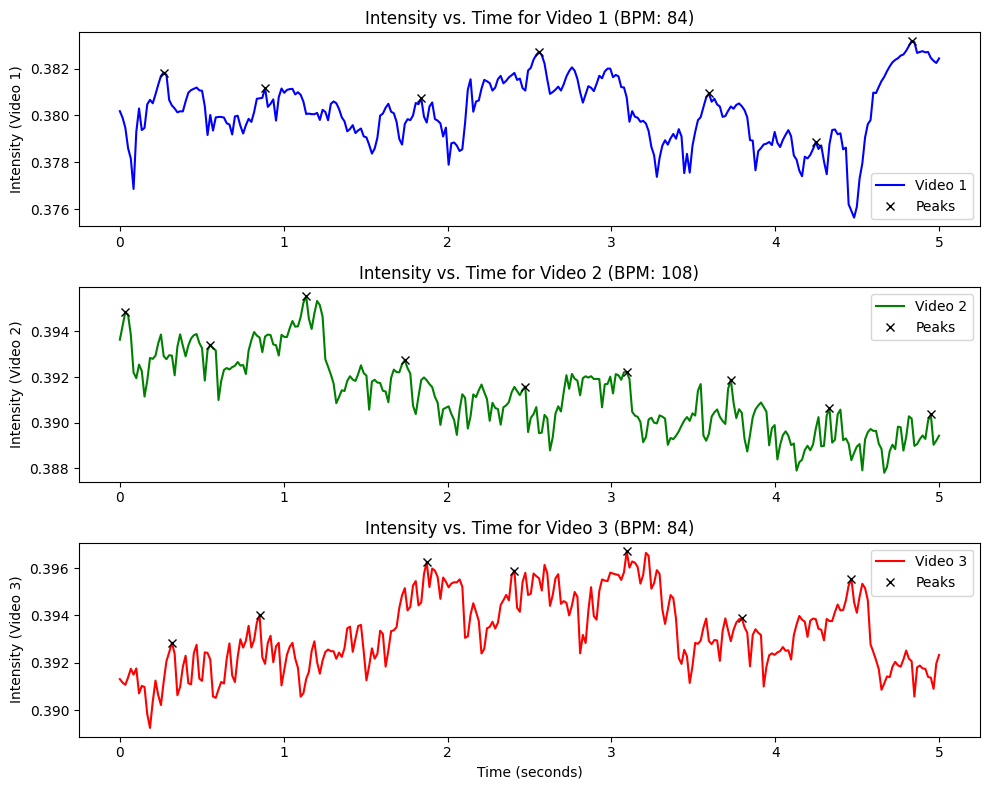

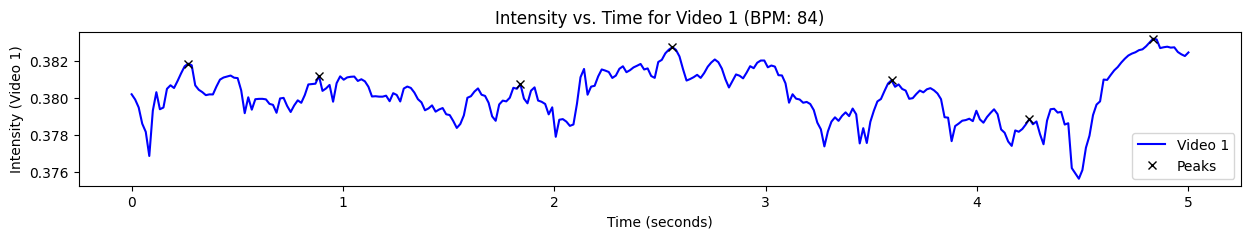

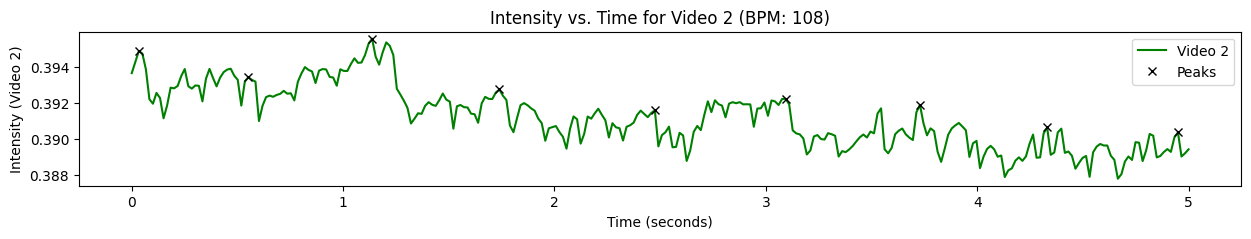

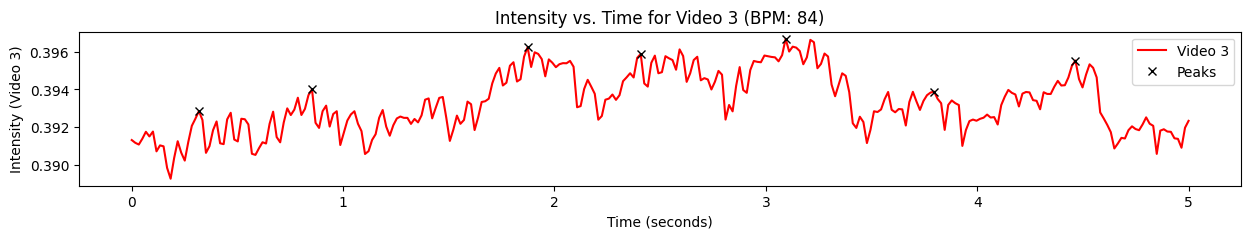

In [15]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments
chunkInfos = {"1": [], "2": [], "3": []}

# Create dictionaries to store the chunks and time axes for each video
chunks = {"1": [], "2": [], "3": []}
timeAxes = {"1": [], "2": [], "3": []}

# Dictionary to store colors for each video
plotColors = {"1": 'blue', "2": 'green', "3": 'red'}

# Dictionary to store BPM values for each video
bpmValues = {"1": 0, "2": 0, "3": 0}

# Extract a random 5-second chunk of frames from each video
def get_random_chunk(frames, videoIndex, fps, duration=5):
    # Calculate the number of frames in the chunk (fps * duration)
    chunkSize = int(fps * duration)
    # print("chunkSize - " + str(chunkSize))
    
    # Ensure we have enough frames to select a random chunk
    if len(frames) < chunkSize:
        raise ValueError(f"Video {videoIndex} has fewer frames than needed for a {duration}-second chunk.")
    
    # Select a random starting frame index such that we can extract a full 5-second chunk
    # print("len(intensityMetrics[videoIndex]) - " + str(len(intensityMetrics[videoIndex])))
    startFrame = random.randint(0, len(frames) - chunkSize)
    # print("startFrame - " + str(startFrame))
    
    chunkInfos[str(videoIndex)] = {'chunkSize': chunkSize, 'startFrame': startFrame}

    # Extract the chunk of intensity values
    return intensityMetrics[videoIndex][startFrame:startFrame + chunkSize]

def plot_intensity_metric_bpm():
    # Plot the intensity metrics over time for the three videos
    # fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig, ax = plt.subplots(3, 1, figsize=(10, 8))

    # Iterate over each video to plot the data and show peaks
    for i, videoIndex in enumerate(intensityMetrics):
        intensityValues = [frameData['intensityMetric'] for frameData in chunks[videoIndex]]
        ax[i].plot(timeAxes[videoIndex], intensityValues, color=plotColors[videoIndex], label=f"Video {videoIndex}")
        
        # Mark the peaks
        peaks, _ = find_peaks(intensityValues, distance=framesPerSecondValues[videoIndex] * 0.5)
        ax[i].plot(timeAxes[videoIndex][peaks], np.array(intensityValues)[peaks], "x", color='black', label="Peaks")
        
        ax[i].set_ylabel(f"Intensity (Video {videoIndex})")
        ax[i].set_title(f"Intensity vs. Time for Video {videoIndex} (BPM: {bpmValues[videoIndex]})")
        ax[i].legend()
        plt.xlabel("Time (seconds)")
    # Common X-axis label
    # plt.xlabel("Time (seconds)")

    # Show the plot
    plt.tight_layout()
    plt.show()

    for i, videoIndex in enumerate(intensityMetrics):
        # Create a new figure and axis for each plot
        fig, ax = plt.subplots(figsize=(15, 2))
        # Plot the intensity over time for the current video
        intensityValues = [frameData['intensityMetric'] for frameData in chunks[videoIndex]]
        ax.plot(timeAxes[videoIndex], intensityValues, color=plotColors[videoIndex], label=f"Video {videoIndex}")
        # Mark the peaks
        peaks, _ = find_peaks(intensityValues, distance=framesPerSecondValues[videoIndex] * 0.5)
        ax.plot(timeAxes[videoIndex][peaks], np.array(intensityValues)[peaks], "x", color='black', label="Peaks")
        # Set Y-axis label for intensity
        ax.set_ylabel(f"Intensity (Video {videoIndex})")
        # Set X-axis label for time
        ax.set_xlabel("Time (seconds)")
        # Set title for each plot
        ax.set_title(f"Intensity vs. Time for Video {videoIndex} (BPM: {bpmValues[videoIndex]})")
        # Enable legend
        ax.legend()
        # Display the plot
        plt.show()
        
# Extract 5-second chunks from the intensity metrics for each video
for videoIndex, frames in intensityMetrics.items():
    chunks[videoIndex] = get_random_chunk(frames, videoIndex, framesPerSecondValues[videoIndex])
    # print("chunks.len : " + str(len(chunks[videoIndex])))
    # for chunk in chunks[videoIndex]:
    #     print("chunk " + str(chunk))

    timeAxes[videoIndex] = np.linspace(0, 5, len(chunks[videoIndex]))
    # print("timeAxes.len : " + str(len(timeAxes[videoIndex])))
    # for timeAxe in timeAxes[videoIndex]:
        # print("timeAxes " + str(timeAxe))

    # Calculate the peaks in the chunk to estimate BPM
    intensityValues = [frameData['intensityMetric'] for frameData in chunks[videoIndex]]
    peaks, _ = find_peaks(intensityValues, distance=framesPerSecondValues[videoIndex] * 0.5)
    totalPeaks = len(peaks)
    
    # Estimate BPM based on number of peaks in 5 seconds
    bpmValues[videoIndex] = totalPeaks * 12  # 12 because 60 / 5 seconds = 12


# Output BPM values for each video
for videoIndex, bpm in bpmValues.items():
    print(f"Video {videoIndex} - Estimated BPM: {bpm}")

plot_intensity_metric_bpm()




#### D. Likelihood Distributions [20 marks]
In the 5-second chunks taken above, choose 20 frames where your sensing metric is close to the local maximum (Case1), and 20 frames where it is close to the local minimum (Case2). Plot the histograms on "R", "G" and "B" values for each pixel in the 20 frames for the two cases 1 and 2. For each video there will be 3 figures, each for "R", "G" and "B". Which one produces the most separable distributions?

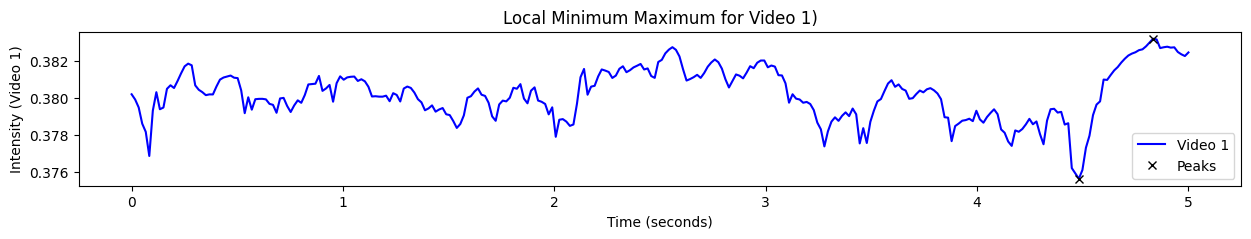

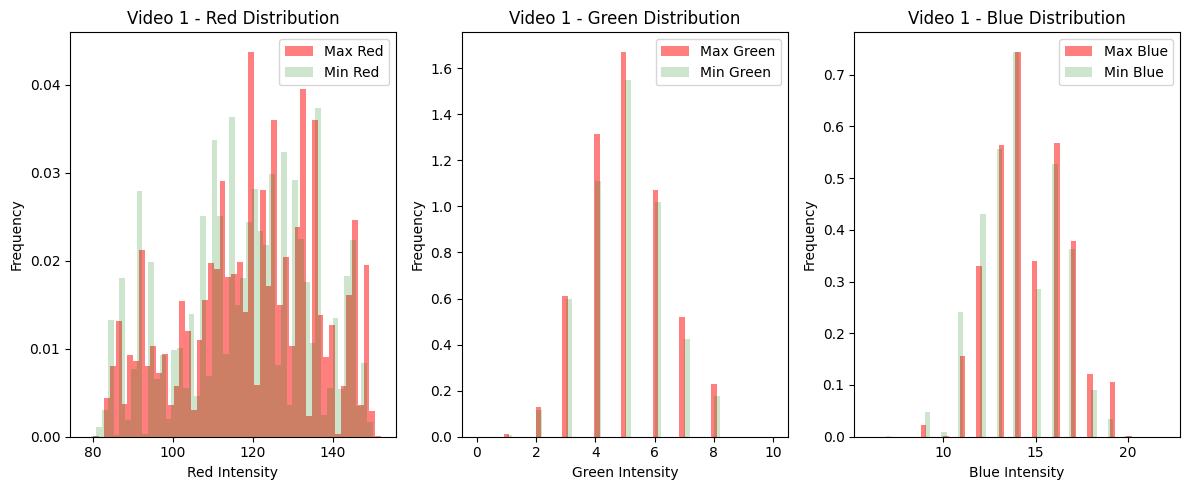

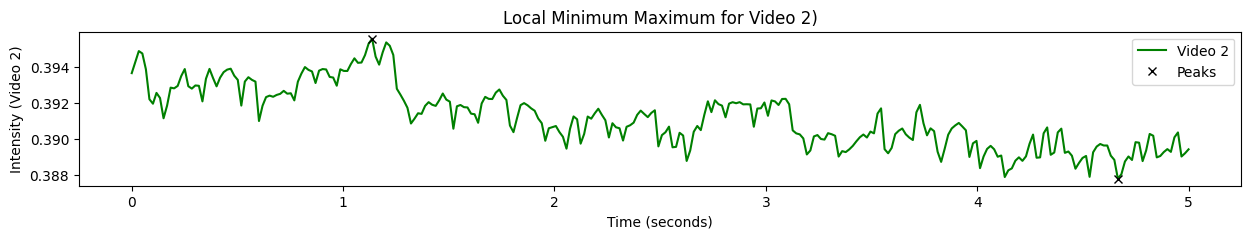

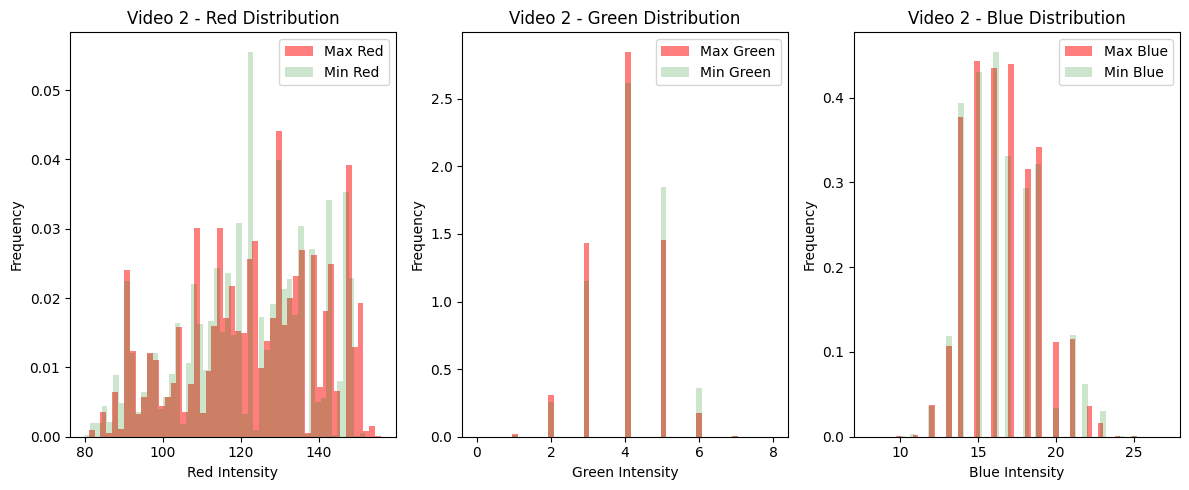

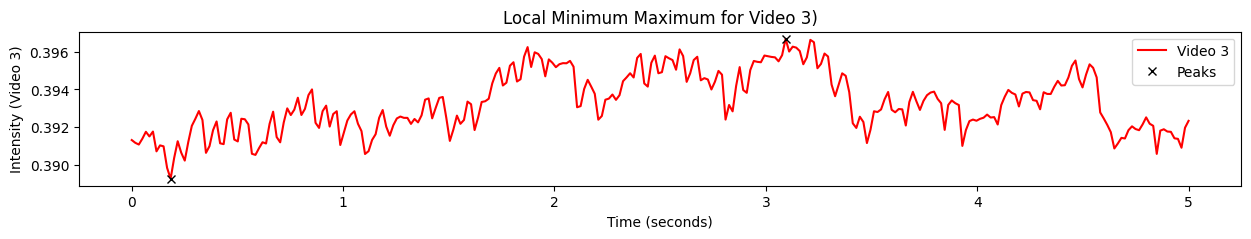

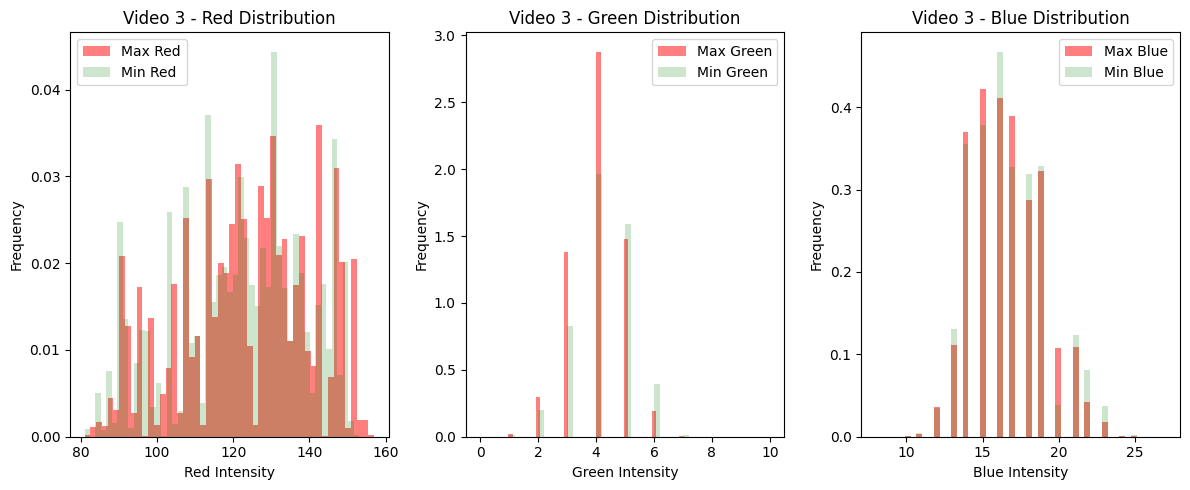

In [16]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments

def select_extreme_frames(intensityChunk, chunkInfo, videoIndex, numFrames=20):
    # print("intensity - " + str(intensityChunk))
    # Find maximum and minimum
    # intensityValues = [frame['intensityMetric'] for frame in intensityChunk]
    # maxima = max(intensityValues)
    # minima = min(intensityValues)

    # print("min - " + str(minima) + " max - " + str(maxima))

    # min_pair = min(intensityChunk, key=lambda x: x['intensityMetric'])
    min_index, min_pair = min(enumerate(intensityChunk), key=lambda x: x[1]['intensityMetric'])
    min_intensity = min_pair['intensityMetric']
    min_frame_index = min_pair['frameIndex']
    # print("min_intensity - " + str(min_intensity))
    # print("min_frame_index - " + str(min_frame_index))

    # max_pair = max(intensityChunk, key=lambda x: x['intensityMetric'])
    max_index, max_pair = max(enumerate(intensityChunk), key=lambda x: x[1]['intensityMetric'])
    max_intensity = max_pair['intensityMetric']
    max_frame_index = max_pair['frameIndex']
    # print("max_intensity - " + str(max_intensity))
    # print("max_frame_index - " + str(max_frame_index))

    # Sort the list based on distance from the minimum
    # minFrames = sorted(intensityChunk, key=lambda x: abs(x['intensityMetric'] - min_intensity))[:numFrames]

    # Sort the list based on distance from the maximum
    # maxFrames = sorted(intensityChunk, key=lambda x: abs(x['intensityMetric'] - max_intensity))[:numFrames]

    # Sort the list based on distance from the minimum
    minFrames = sorted(intensityChunk, key=lambda x: abs(x['frameIndex'] - min_frame_index))[:numFrames]

    # Sort the list based on distance from the maximum
    maxFrames = sorted(intensityChunk, key=lambda x: abs(x['frameIndex'] - max_frame_index))[:numFrames]

    # print("max " + str(maxFrames))
    # print("min " + str(minFrames))
    # for ma in maxFrames:
    #     print("maxima - " + str(ma['frameIndex']) + " " + str(ma['intensityMetric']))
    # for mi in minFrames:
    #     print("minima - " + str(mi['frameIndex']) + " " + str(mi['intensityMetric']))

    return maxFrames, minFrames, max_index, min_index

# Function to extract R, G, B values from selected frames
def extract_rgb_values_histogram_1D(frames, videoIndex):
    if len(frames) == 0:  # Handle case where no frames are selected
        return np.array([]), np.array([]), np.array([])
    
    redValues, greenValues, blueValues = [], [], []
    totalBluePixels = 0
    totalGreenPixels = 0
    totalRedPixels = 0
    for frame in frames:
        frameIndex = frame['frameIndex']
        # print("frameIndex " + str(frameIndex))
        frameTemp = videoFrames[videoIndex][frameIndex]
        blue, green, red = cv2.split(frameTemp)
        blueHeight, blueWidth = blue.shape
        # print("blue " + str(blue.shape) + " " + str(blueHeight) + " " + str(blueWidth))
        greenHeight, greenWidth = green.shape
        # print("green " + str(green.shape) + " " + str(greenHeight) + " " + str(greenWidth))
        redHeight, redWidth = red.shape
        # print("red " + str(red.shape) + " " + str(redHeight) + " " + str(redWidth))

        totalBluePixels = totalBluePixels + blueHeight*blueWidth
        totalGreenPixels = totalGreenPixels + greenHeight*greenWidth
        totalRedPixels = totalRedPixels + redHeight*redWidth

        redValues.append(red.ravel())
        greenValues.append(green.ravel())
        blueValues.append(blue.ravel())
    
    # print("totalBluePixels " + str(totalBluePixels))
    # print("totalGreenPixels " + str(totalGreenPixels))
    # print("totalRedPixels " + str(totalRedPixels))

    return np.concatenate(redValues), np.concatenate(greenValues), np.concatenate(blueValues)

def plot_local_min_max(minFrames, maxFrames, minIndices, maxIndices, intensityChunk, videoIndex):
    # Create a new figure and axis for each plot
    fig, ax = plt.subplots(figsize=(15, 2))
    # Plot the intensity over time for the current video
    intensityValues = [frameData['intensityMetric'] for frameData in intensityChunk]
    ax.plot(timeAxes[videoIndex], intensityValues, color=plotColors[videoIndex], label=f"Video {videoIndex}")
    # Mark the peaks
    # peaks, _ = find_peaks(intensityValues, distance=framesPerSecondValues[videoIndex] * 0.5)
    # print("peaks - " + str(peaks))
    ax.plot(timeAxes[videoIndex][[minIndices[videoIndex], maxIndices[videoIndex]]], np.array(intensityValues)[[minIndices[videoIndex], maxIndices[videoIndex]]], "x", color='black', label="Peaks")
    # Set Y-axis label for intensity
    ax.set_ylabel(f"Intensity (Video {videoIndex})")
    # Set X-axis label for time
    ax.set_xlabel("Time (seconds)")
    # Set title for each plot
    ax.set_title(f"Local Minimum Maximum for Video {videoIndex})")
    # Enable legend
    ax.legend()
    # Display the plot
    plt.show()

# Plot histograms for R, G, B values in both cases
def plot_histograms(redMax, greenMax, blueMax, redMin, greenMin, blueMin, videoIndex):
    
    if len(redMax) == 0 or len(redMin) == 0:
        print(f"Not enough data for Video {videoIndex} to plot histograms.")
        return
    
    colors = ['red', 'green', 'blue']
    channels = ['Red', 'Green', 'Blue']
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    
    for i, (max_vals, min_vals) in enumerate(zip([redMax, greenMax, blueMax], [redMin, greenMin, blueMin])):
        # Plot max case
        axs[i].hist(max_vals, bins=50, color='red', alpha=0.5, label=f'Max {channels[i]}', density=True)
        # axs[i].set_title(f'Video {videoIndex} - Max {channels[i]} Distribution')
        # axs[i].set_xlabel(f'{channels[i]} Intensity')
        # axs[i].set_ylabel('Frequency')
        # axs[i].legend()
        
        # Plot min case
        axs[i].hist(min_vals, bins=50, color='green', alpha=0.2, label=f'Min {channels[i]}', density=True)
        axs[i].set_title(f'Video {videoIndex} - {channels[i]} Distribution')
        axs[i].set_xlabel(f'{channels[i]} Intensity')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Create dictionaries to store maxFrames and minFrames for each video
maxFrames = {}
minFrames = {}
maxIndices={}
minIndices={}

# For each video, select frames near maxima and minima and plot histograms
for videoIndex in videoFrames:
    # Get intensity values for the 5-second chunk
    intensityChunk = chunks[videoIndex]
    chunkInfo = chunkInfos[videoIndex]

    # Select 20 frames near maxima and minima
    maxFrame, minFrame, max_index, min_index = select_extreme_frames(intensityChunk, chunkInfo, videoIndex)
    # Store maxFrames and minFrames for the given videoIndex
    maxFrames[videoIndex] = maxFrame
    minFrames[videoIndex] = minFrame
    maxIndices[videoIndex] = max_index
    minIndices[videoIndex] = min_index
    
    # Extract R, G, B values for the selected frames
    redMax, greenMax, blueMax = extract_rgb_values_histogram_1D(maxFrame, videoIndex)
    redMin, greenMin, blueMin = extract_rgb_values_histogram_1D(minFrame, videoIndex)
    
    plot_local_min_max(minFrames, maxFrames, minIndices, maxIndices, intensityChunk, videoIndex)
    # Plot histograms for R, G, B distributions
    plot_histograms(redMax, greenMax, blueMax, redMin, greenMin, blueMin, videoIndex)

#### E. Threshold Based Detection and ROC curve [25 marks]
Only consider the "R" channel for analysis. Suppose, we just use a single pixel (uniformly randomly chosen in the frame) to detect whether the frame belongs to case 1 or case 2. You can denote the "Case 1" to be the POSITIVE event/hypothesis and "Case 2" to be the NEGATIVE event/null hypothesis. For every threshold value, for every frame, choose 500 random pixels. Compute the "Probability of Detection" ($P_D$) and "Probability of False Alarm" ($P_{FA}$). Note that you have (20 + 20) = 40 frames, and 500 detections per frame, i.e., 20000 total detections. Plot the $ROC$ curve. Which one has the best ROC curve (Dataset 1, 2 or 3)?

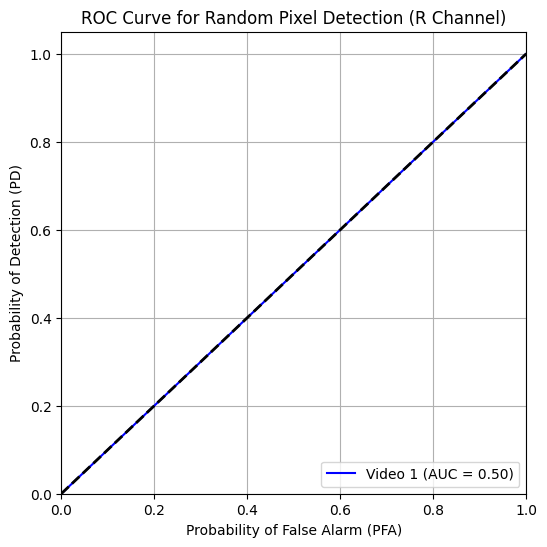

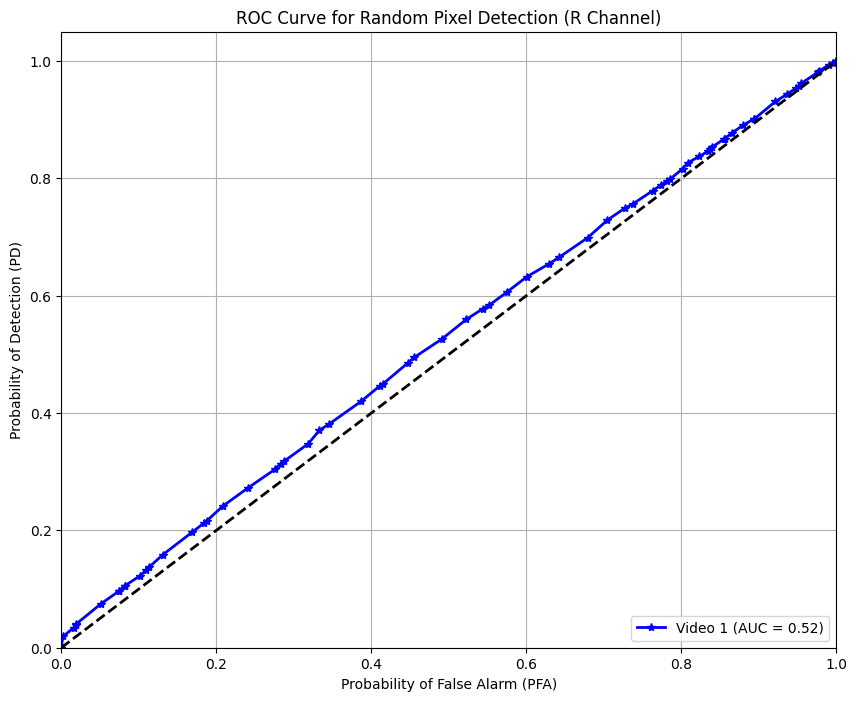

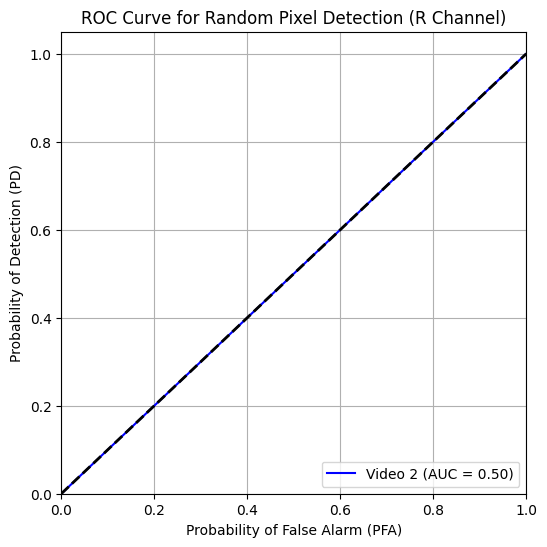

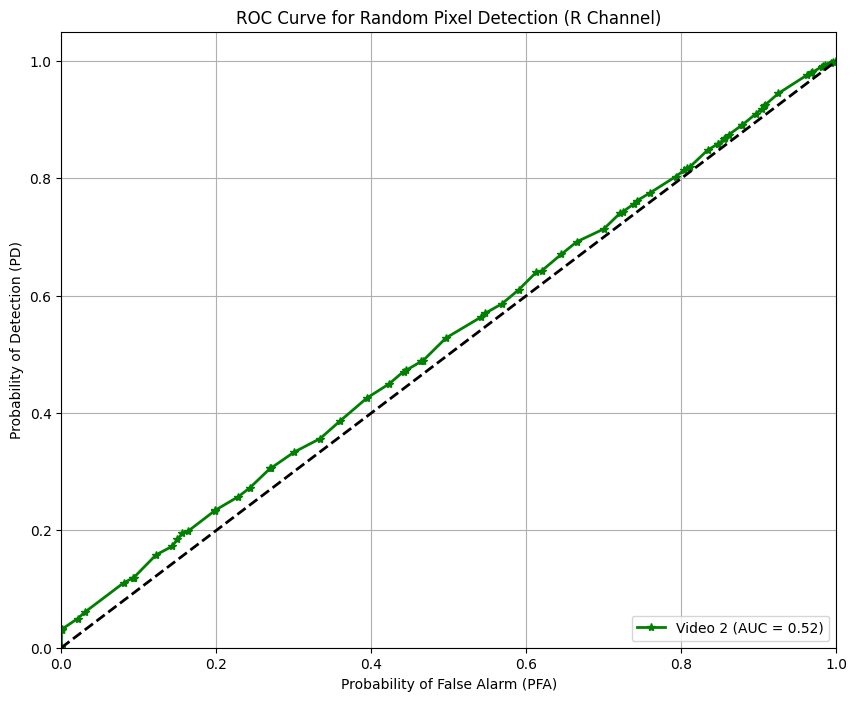

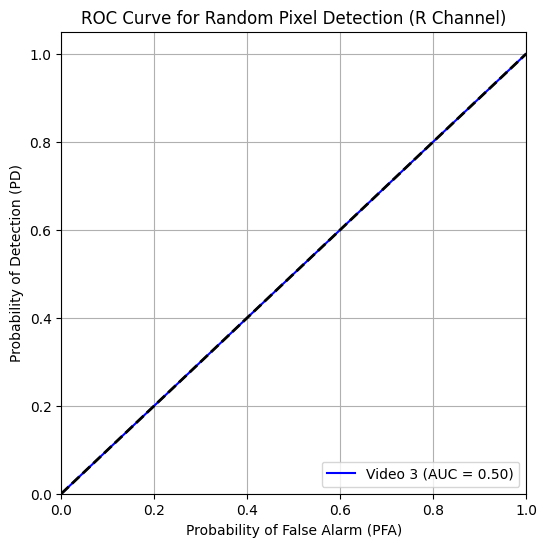

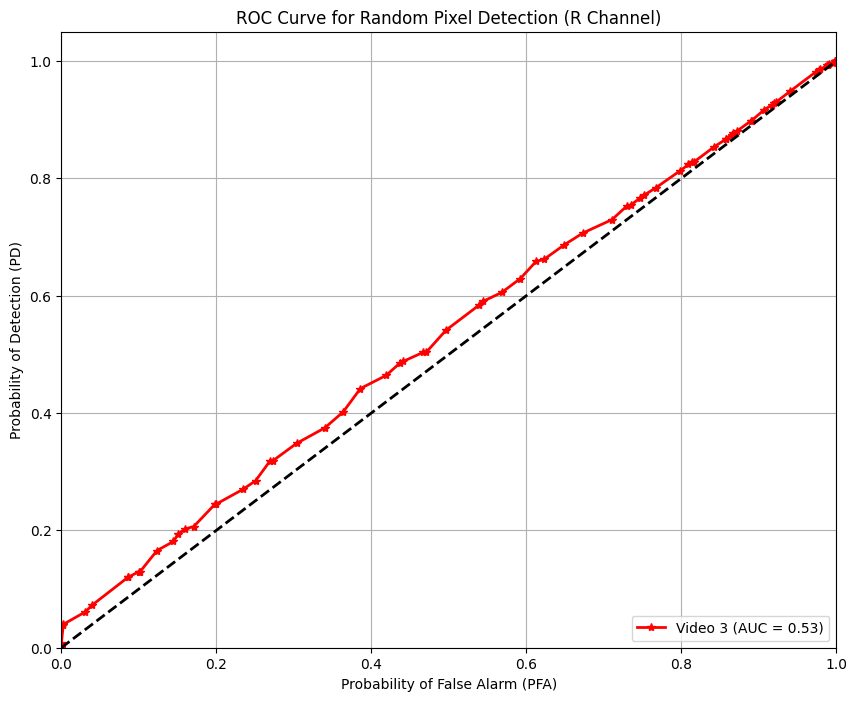

Video 1 AUC Score: 0.50
Video 2 AUC Score: 0.50
Video 3 AUC Score: 0.50

The video with the best ROC curve (highest AUC) is Video 1 with an AUC score of 0.50


In [17]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments
def trapezoid_integration(x, y):
    """
    Compute the area under the curve using the trapezoidal rule.

    Parameters:
    - x: List or array of x-values (e.g., False Positive Rates or thresholds)
    - y: List or array of y-values (e.g., True Positive Rates or outputs)

    Returns:
    - area: The calculated area under the curve.
    """
    area = 0.0

    # Iterate over each pair of points and sum the area of each trapezoid
    for i in range(1, len(x)):
        # Calculate the width of the trapezoid (difference in x-values)
        width = x[i] - x[i - 1]
        # Calculate the height of the trapezoid (average of the two y-values)
        height = (y[i] + y[i - 1]) / 2.0
        # Add the area of the trapezoid to the total area
        area += width * height

    return area

def calculate_auc(pfa, pd):
    """
    Calculate the Area Under the Curve (AUC) for the ROC curve using the trapezoidal rule.
    
    Parameters:
    - pfa: List or array of False Positive Rates (Pfa)
    - pd: List or array of True Positive Rates (Pd)
    
    Returns:
    - auc: Calculated AUC value
    """
    pfa = np.array(pfa)
    pd = np.array(pd)

    # Sort pfa and corresponding pd values to ensure proper calculation
    sorted_indices = np.argsort(pfa)
    pfa = pfa[sorted_indices]
    pd = pd[sorted_indices]

    # Calculate AUC using the trapezoidal rule
    auc = np.trapezoid(pd, pfa)
    # auc = trapezoid_integration(pd, pfa)

    return auc


def my_compute_roc_curve(redPixelsMax, redPixelsMin, thresholds, videoIndex, rpfa, rpd):
    """
    Computes and plots the ROC curve based on redPixelsMax and redPixelsMin values.

    Parameters:
    - redPixelsMax: List or array of max pixel values (e.g., for positive events)
    - redPixelsMin: List or array of min pixel values (e.g., for negative events)
    - thresholds: List of thresholds for likelihood ratio test

    Returns:
    - pd: List of probability of detection (Pd) values for each threshold
    - pfa: List of probability of false alarm (Pfa) values for each threshold
    """
    
    # Combine the pixel values
    pixelValues = np.concatenate([redPixelsMax, redPixelsMin])

    # Fit normal distributions for the max and min pixel values
    maxMu, maxStd = norm.fit(redPixelsMax)
    minMu, minStd = norm.fit(redPixelsMin)
    # print("redPixelsMax " + str(redPixelsMax.shape))
    # print("maxMu " + str(maxMu))
    # print("maxStd " + str(maxStd))    
    # print("minMu " + str(minMu))
    # print("minStd " + str(minStd))

    # Calculate likelihoods for both hypotheses
    pH0 = norm.pdf(pixelValues, minMu, minStd)  # Likelihood for H1 (positive event)
    pH1 = norm.pdf(pixelValues, maxMu, maxStd)  # Likelihood for H0 (negative event)

    # Initialize lists to store Pd and Pfa for each threshold
    pd = []
    pfa = []

    # thresholds = [i/j for i, j in zip(rpd,rpfa) if j != 0 ]
    # print("thresholds - " + str(thresholds))
    # Loop through each threshold to compute Pd and Pfa
    for threshold in thresholds:
    # for threshold in np.arange(0, 1.5, .1):
        # Likelihood ratio test
        classifications = pH1 >= (threshold) * pH0
        # print("pH1 - " + str(pH1))
        # print("pH0 - " + str(pH0))
        # print("threshold - " + str(threshold/255))
        
        # Compute Pd (True Positive Rate) and Pfa (False Positive Rate)
        Pd = np.sum(classifications[:len(redPixelsMax)+1]) / len(redPixelsMax)  # Detection rate for positive events
        Pfa = np.sum(classifications[-len(redPixelsMin):]) / len(redPixelsMin)  # False alarm rate for negative events
        
        # print(f"threshold {threshold} tp {np.sum(classifications[:len(redPixelsMax)+1])} fp {np.sum(classifications[-len(redPixelsMin):])}")

        # Store the results
        pd.append(Pd)
        pfa.append(Pfa)

    auc_value = auc(pfa, pd)
    myauc = calculate_auc(pfa, pd)


    # print("mypfa - " + str(pfa))
    # print("mypd - " + str(pd))

    # print("auc_value - " + str(auc_value))
    # print("myauc " + str(myauc))

    # Plot the ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(pfa, pd, linestyle='-', color='b', label=f'Video {videoIndex} (AUC = {myauc:.2f})')
    plt.title("ROC Curve")
    plt.xlabel("Pfa (Probability of False Alarm)")
    plt.ylabel("Pd (Probability of Detection)")
    plt.grid(True)
    plt.legend()
    # plt.show()

    # Add diagonal reference line for random guessing
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Probability of False Alarm (PFA)')
    plt.ylabel('Probability of Detection (PD)')
    plt.title('ROC Curve for Random Pixel Detection (R Channel)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Print Pd and Pfa for each threshold
    # for t, Pd_val, Pfa_val in zip(thresholds, pd, pfa):
    #     print(f"Threshold: {t}, Pd: {Pd_val:.4f}, Pfa: {Pfa_val:.4f}")

    return pd, pfa, myauc

# Function to compute the ROC curve
def compute_roc_curve(redPixelsMax, redPixelsMin):

    # Create labels: 1 for case 1 (positive), 0 for case 2 (negative)
    labels = np.concatenate([np.ones(len(redPixelsMax)), np.zeros(len(redPixelsMin))])

    # Concatenate the R channel pixel intensities
    pixelValues = np.concatenate([redPixelsMax, redPixelsMin])

    # Loop over a range of thresholds to calculate PD and PFA
    pfa, pd, thresholds = roc_curve(labels, pixelValues)
    rocAuc = auc(pfa, pd)

    # print("pfa - " + str(pfa))
    # print("pd - " + str(pd))
    # print("thresholds - " + str(thresholds))
    # print("rocAuc - " + str(rocAuc))

    return pfa, pd, thresholds, rocAuc

# Function to extract R, G, B values from selected frames
def extract_rgb_values_2D(frames, videoIndex):
    redFrames = []
    greenFrames = []
    blueFrames = []

    for frame in frames:
        frameIndex = frame['frameIndex']
        frameTemp = videoFrames[videoIndex][frameIndex]
        blue, green, red = cv2.split(frameTemp)  # Separate B, G, R channels
        
        redFrames.append(red)
        greenFrames.append(green)
        blueFrames.append(blue)

    return redFrames, greenFrames, blueFrames

# Function to randomly select 500 pixels from each frame
def random_pixel_selection(frames, numPixels=500):
    selectedPixels1D = []
    selectedPixelsCols = []
    selectedPixelsRows = []

    for frame in frames:
        # Get the dimensions of the frame (height, width)
        height, width = frame.shape

        # Randomly select pixels from the flattened array of pixel values
        randomIndices = np.random.choice(height * width, numPixels, replace=False)
        row, col = np.unravel_index(randomIndices, frame.shape)
        # print(f"col {col}")
        # print(f"row {row}")
        selectedPixelsRows.append(row)
        selectedPixelsCols.append(col)
        selectedPixels = frame.flatten()[randomIndices]
        selectedPixels1D.append(selectedPixels)  # Extract pixel values
        # for i in randomIndices:
        #     print(f"randomIndices {divmod(i, width)}")
        # for i in range(numPixels):
        #     print(f"frame[{row[i]}][{col[i]}] {frame[row[i]][col[i]]}")
        # print(f"selectedPixels1D[-1][0] {selectedPixels1D[-1][0]}")
        # print(f"selectedPixels {selectedPixels}")
        # print(f"frame[{row[100]}][{col[100]}] {frame[row[100]][col[100]]}")
        # print(f"selectedPixels1D[100] {selectedPixels1D[0][100]}")

    return np.concatenate(selectedPixels1D), np.concatenate(selectedPixelsRows), np.concatenate(selectedPixelsCols)

# def get_red_pixels_max_min(redMax, redMin):
#     redPixelsMax, redPixelsMaxRows, redPixelsMaxCols  = random_pixel_selection(redMax)
#     redPixelsMin, redPixelsMinRows, redPixelsMinCols = random_pixel_selection(redMin)

#     return redPixelsMax, redPixelsMaxRows, redPixelsMaxCols, redPixelsMin, redPixelsMinRows, redPixelsMinCols

# Plot ROC curves for all videos
def plot_roc_curves():
    colors = ['blue', 'green', 'red']
    aucScores = {}
    pdPfaThresholds = {}  # To store PD and PFA values for each video
    redPixels = {}
    redPixelsRows = {}
    redPixelsCols = {}

    for index, videoIndex in enumerate(videoFrames):
        # Extract R channel frames for max and min cases
        redMax, _, _ = extract_rgb_values_2D(maxFrames[videoIndex], videoIndex)
        redMin, _, _ = extract_rgb_values_2D(minFrames[videoIndex], videoIndex)

        # print("redMax " + str(redMax))
        # print("redMin " + str(redMin))

        # Select 500 random pixels from each frame in both cases
        redPixelsMax, redPixelsMaxRows, redPixelsMaxCols = random_pixel_selection(redMax)
        redPixelsMin, redPixelsMinRows, redPixelsMinCols = random_pixel_selection(redMin)

        # Store Red pixels max and min
        redPixels[videoIndex] = {"RedPixelsMax": redPixelsMax, "RedPixelsMin": redPixelsMin}
        redPixelsRows[videoIndex] = {"RedPixelsMaxRows": redPixelsMaxRows, "RedPixelsMinRows": redPixelsMinRows}
        redPixelsCols[videoIndex] = {"RedPixelsMaxCols": redPixelsMaxCols, "RedPixelsMinCols": redPixelsMinCols}

        # print("redPixelsMax " + str(redPixelsMax))
        # print("redPixelsMin " + str(redPixelsMin))
        # for red in redPixelsMax:
        #     print(f"red['frameIndex] {red['frameIndex']} red['intensityMetric] {red[intensityMetric]}")
        combined_pixels = redPixelsMax + redPixelsMin
        unique_pixel_values = set(combined_pixels)
        unique_pixel_values_sorted = sorted(unique_pixel_values)
        # print("unique_pixel_values_sorted " + str(len(unique_pixel_values_sorted)))

        # Compute ROC curve
        pfa, pd, thresholds, rocAuc = compute_roc_curve(redPixelsMax, redPixelsMin)
        # print("pfa - " + str(pfa) + " pd - " + str(pd))

        # print("unique_pixel_values_sorted " + str(unique_pixel_values_sorted))
        # thres = [0.5, 1, 1.5]
        # thres = np.arange(255, 154, -1)
        thres = np.arange(0.5, 1.5, 0.1)
        thres = np.linspace(0, 255, 50)
        # thres = unique_pixel_values_sorted#np.arange(255, 154, -1)
        # thres = thresholds
        mypd, mypfa, auc  = my_compute_roc_curve(redPixelsMax, redPixelsMin, thres, videoIndex, pfa, pd)
        # print("mypfa - " + str(mypfa) + " mypd - " + str(mypd))

        # Store AUC score
        aucScores[videoIndex] = auc

        # Store PD (tpr) and PFA (fpr) for each video
        pdPfaThresholds[videoIndex] = {"PD": mypd, "PFA": mypfa, "Thresholds": thres}

        # Plot ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(pfa, pd, color=colors[index], lw=2, label=f'Video {videoIndex} (AUC = {rocAuc:.2f})', marker='*')

        # Add diagonal reference line for random guessing
        plt.plot([0, 1], [0, 1], 'k--', lw=2)  
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Probability of False Alarm (PFA)')
        plt.ylabel('Probability of Detection (PD)')
        plt.title('ROC Curve for Random Pixel Detection (R Channel)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    return aucScores, pdPfaThresholds, redPixels, redPixelsRows, redPixelsCols

# Call the function to plot ROC curves for all three videos
aucScores, pdPfaThresholds, redPixels, redPixelsRows, redPixelsCols = plot_roc_curves()

# Print AUC scores for each video
for videoIndex, aucScore in aucScores.items():
    print(f"Video {videoIndex} AUC Score: {aucScore:.2f}")

# Determine the video with the best AUC score
bestVideoId = max(aucScores, key=aucScores.get)
print(f"\nThe video with the best ROC curve (highest AUC) is Video {bestVideoId} with an AUC score of {aucScores[bestVideoId]:.2f}")

# Print PD and PFA values for each video
# for video_id, values in pdPfaThresholds.items():
#     pd_values = values["PD"]
#     pfa_values = values["PFA"]
#     thres_values = values["Thresholds"]
#     print(f"\nVideo {video_id} PD and PFA values:")
#     for i, (pd, pfa) in enumerate(zip(pd_values, pfa_values)):
#         print(f"Threshold {i+1}: PD = {pd:.4f}, PFA = {pfa:.4f}, Thresholds = {thres_values}")


#### F. Are "good" samples spatially correlated? [20 marks]
First, choose an optimal threshold, $T_{OPT}$, that best suits your data (maximize $P_D$ while minimizing $P_{FA}$, you may look into maximizing the $\frac{P_D}{P_{FA}}$ ratio). Out of the 20000 total detections above for $T_{OPT}$, can it be hypothesised that the "good" samples (true positives and true negatives) are spatially clustered in certain areas of the frame, compared to the "bad" samples (false positives and false negatives)?

T_OPT 0.0 max_pd 1.0001 min_pfa 1.0


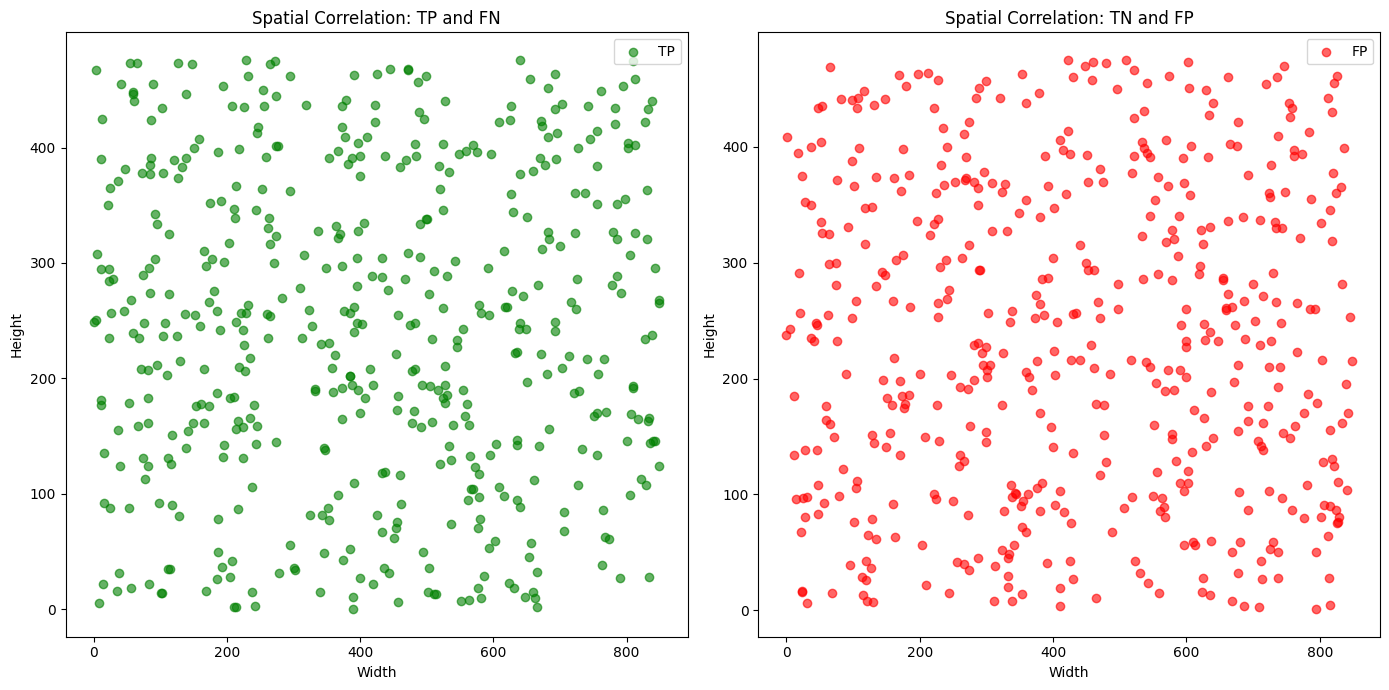

T_OPT 0.0 max_pd 1.0001 min_pfa 1.0


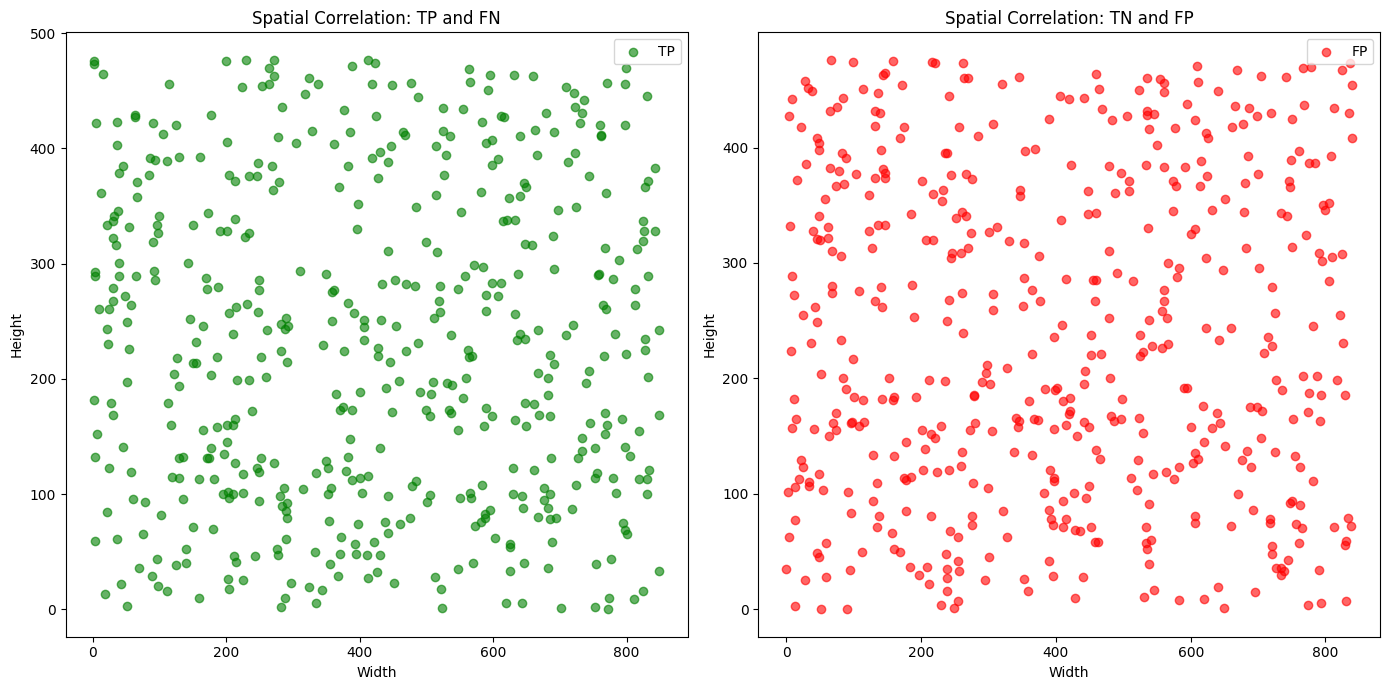

T_OPT 0.0 max_pd 1.0001 min_pfa 1.0


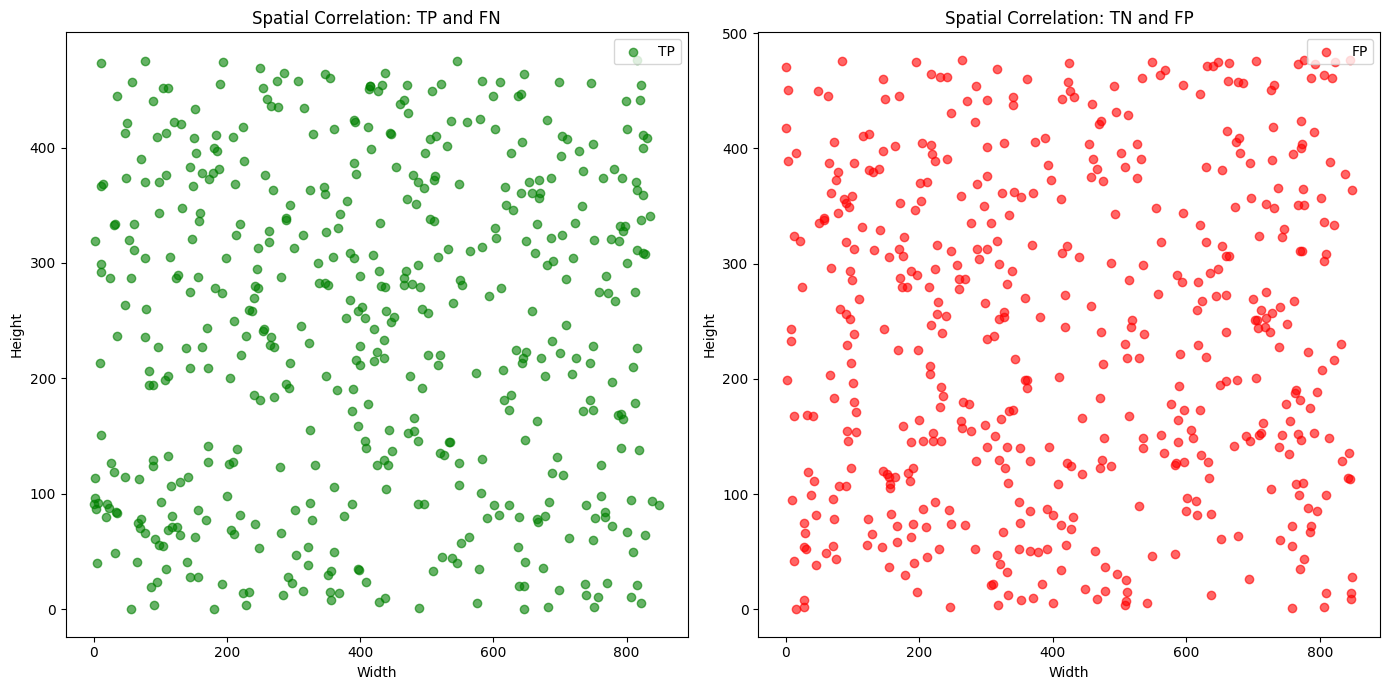

In [18]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments

# Function to find optimal threshold T_OPT
def find_optimal_threshold(pfa, pd, thresholds):

    # pd_pfa_ratios = []
    # Calculate the PD/PFA ratio for each threshold
    non_zero_mask = pfa != 0
    pd_pfa_ratios = np.full_like(pfa, np.nan)
    pd_pfa_ratios[non_zero_mask] = pd[non_zero_mask] / pfa[non_zero_mask]
    # pd_pfa_ratios = pd / (pfa)  # Adding a small value to avoid division by zero
    # pd_pfa_ratios = pd / (pfa + 1e-6)  # Adding a small value to avoid division by zero
    pd_pfa_ratios[~non_zero_mask] = 0
    # Find the index of the maximum ratio
    optimal_idx = np.argmax(pd_pfa_ratios)
    
    # Get the optimal threshold and corresponding PD and PFA
    T_OPT = thresholds[optimal_idx]
    max_pd = pd[optimal_idx]
    min_pfa = pfa[optimal_idx]
    
    return T_OPT, max_pd, min_pfa

# # Function to classify samples based on T_OPT
def classify_samples(redPixelsMax, redPixelsMaxRow, redPixelsMaxCol, redPixelsMin, redPixelsMinRow, redPixelsMinCol, T_OPT):

    pixelValues = np.concatenate([redPixelsMax, redPixelsMin])
    pixelRows = np.concatenate([redPixelsMaxRow, redPixelsMinRow])
    pixelCols = np.concatenate([redPixelsMaxCol, redPixelsMinCol])

    maxMu, maxStd = norm.fit(redPixelsMax)
    minMu, minStd = norm.fit(redPixelsMin)

    # print("maxMu " + str(maxMu))
    # print("maxStd " + str(maxStd))    
    # print("minMu " + str(minMu))
    # print("minStd " + str(minStd))

    pH0 = norm.pdf(pixelValues, minMu, minStd)  # Likelihood for H1 (positive event)
    pH1 = norm.pdf(pixelValues, maxMu, maxStd)  # Likelihood for H0 (negative event)

    classifications = pH1 >= (T_OPT) * pH0

    # print("classifications " + str(classifications))
    true_positives = []
    false_negatives = []
    false_positives = []
    true_negatives = []
    for index, cls in enumerate(classifications):
        pixelData = {'pixelValue' :pixelValues[index] , 'pixelRow':pixelRows[index] , 'pixelCol':pixelCols[index]}
        if(index < len(redPixelsMax)):
            if(cls == True):
                true_positives.append(pixelData)
            else:
                false_negatives.append(pixelData)
        else:
            if(cls == True):
                false_positives.append(pixelData)
            else:
                true_negatives.append(pixelData)
    # print("T_OPT " + str(T_OPT) )
    # print("true_positives " + str(len(true_positives)))
    # print("false_negatives " + str(len(false_negatives)))
    # print("false_positives " + str(len(false_positives)))
    # print("true_negatives " + str(len(true_negatives)))
    return true_positives, true_negatives, false_positives, false_negatives

def plot_spatial_correlation(TP, TN, FP, FN, frame_shape):
    """
    Plots two side-by-side spatial correlation plots:
    1. TP and FN together
    2. TN and FP together

    Parameters:
    - tp_locations: List of (x, y) coordinates for True Positives (TP).
    - fn_locations: List of (x, y) coordinates for False Negatives (FN).
    - tn_locations: List of (x, y) coordinates for True Negatives (TN).
    - fp_locations: List of (x, y) coordinates for False Positives (FP).
    - frame_shape: Shape of the frame (height, width) for the background.
    """

    # Filter the locations based on labels
    tp_locations = [(pixelData['pixelRow'],pixelData['pixelCol']) for pixelData in TP]
    fn_locations = [(pixelData['pixelRow'],pixelData['pixelCol']) for pixelData in FN]
    tn_locations = [(pixelData['pixelRow'],pixelData['pixelCol']) for pixelData in TN]
    fp_locations = [(pixelData['pixelRow'],pixelData['pixelCol']) for pixelData in FP]
   
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

    # Plot TP and FN in the first subplot (left)
    ax1 = axes[0]
    # ax1.imshow(np.ones(frame_shape), cmap='gray')  # Blank frame background
    ax1.set_facecolor("white")
    
    # Plot TP (True Positives)
    if tp_locations:
        tp_x, tp_y = zip(*tp_locations)
        ax1.scatter(tp_x, tp_y, color='green', alpha=0.6, label="TP")

    # Plot FN (False Negatives)
    if fn_locations:
        fn_x, fn_y = zip(*fn_locations)
        ax1.scatter(fn_x, fn_y, color='orange', alpha=0.6, label="FN")

    ax1.legend(loc="upper right")
    ax1.set_title("Spatial Correlation: TP and FN")
    ax1.set_xlabel("Width")
    ax1.set_ylabel("Height")
    # ax1.invert_yaxis()  # Invert y-axis to place (0,0) at top-left

    # Plot TN and FP in the second subplot (right)
    ax2 = axes[1]
    # ax2.imshow(np.ones(frame_shape), cmap='gray')  # Blank frame background
    ax2.set_facecolor("white")

    # Plot TN (True Negatives)
    if tn_locations:
        tn_x, tn_y = zip(*tn_locations)
        ax2.scatter(tn_x, tn_y, color='blue', alpha=0.6, label="TN")

    # Plot FP (False Positives)
    if fp_locations:
        fp_x, fp_y = zip(*fp_locations)
        ax2.scatter(fp_x, fp_y, color='red', alpha=0.6, label="FP")

    ax2.legend(loc="upper right")
    ax2.set_title("Spatial Correlation: TN and FP")
    ax2.set_xlabel("Width")
    ax2.set_ylabel("Height")
    # ax2.invert_yaxis()  # Invert y-axis to place (0,0) at top-left

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# def plot_spatial_correlation_v2(tp, tn, fp, fn, videoID, f_h, f_w):
#     cmap = sns.color_palette()
#     get_coords = lambda ind: [
#         (ind % f_w).astype(np.float64) / f_w,
#         (ind / f_w).astype(np.float64) / f_h,
#     ]

#     tp_x, tp_y = get_coords(np.array(tp))
#     fn_x, fn_y = get_coords(np.array(fn))
#     tn_x, tn_y = get_coords(np.array(tn))
#     fp_x, fp_y = get_coords(np.array(fp))

#     # Visualize spatial correlation of predictions
#     plt.subplot(1, 2, 1)
#     plt.scatter(tp_x, tp_y, s=8, color=cmap[0], label="True +ve")
#     plt.scatter(fn_x, fn_y, s=8, color=cmap[1], label="False -ve")
#     plt.legend(
#         bbox_to_anchor=(0, 1.02, 1, 0.2),
#         loc="lower left",
#         mode="expand",
#         borderaxespad=0,
#         ncols=2,
#         handletextpad=0,
#     )
#     plt.axis("square")
#     # plt.xticks([0, 0.5, 1])
#     # plt.yticks([0, 0.5, 1])
#     plt.title("Positive Event (Local Maxima)\n\n", fontsize="medium")

#     plt.subplot(1, 2, 2)
#     plt.scatter(tn_x, tn_y, s=8, color=cmap[2], label="True -ve")
#     plt.scatter(fp_x, fp_y, s=8, color=cmap[3], label="False +ve")
#     plt.legend(
#         bbox_to_anchor=(0, 1.02, 1, 0.2),
#         loc="lower left",
#         mode="expand",
#         borderaxespad=0,
#         ncols=2,
#         handletextpad=0,
#     )
#     plt.axis("square")
#     # plt.xticks([0, 0.5, 1])
#     # plt.yticks([0, 0.5, 1])
#     plt.title("Negative Event (Local Minima)\n\n", fontsize="medium")

#     plt.suptitle(
#         f"[Video ID: {videoID}] Spatial Correlation", fontsize=14, fontweight="bold"
#     )
#     plt.show()

# def plot_spatial_correlation_v2(tp, tn, fp, fn, videoID, f_h, f_w):
#     """
#     Plots the spatial correlation of True Positives, True Negatives, 
#     False Positives, and False Negatives across the video frame, 
#     ensuring the points fill the entire plot area.

#     Args:
#         tp (list or array): Indices of True Positives.
#         tn (list or array): Indices of True Negatives.
#         fp (list or array): Indices of False Positives.
#         fn (list or array): Indices of False Negatives.
#         videoID (int): ID of the video.
#         f_h (int): Frame height.
#         f_w (int): Frame width.
#     """
#     # Color map for the scatter plot
#     cmap = sns.color_palette()

#     # Function to get normalized x and y coordinates from pixel indices
#     def get_coords(ind):
#         ind = np.array(ind)  # Ensure it's a numpy array for element-wise operations
#         x_coords = (ind % f_w) / f_w
#         y_coords = (ind // f_w) / f_h  # Integer division to get row index
#         return x_coords, y_coords

#     # Get the coordinates for each class
#     tp_x, tp_y = get_coords(tp)
#     fn_x, fn_y = get_coords(fn)
#     tn_x, tn_y = get_coords(tn)
#     fp_x, fp_y = get_coords(fp)

#     # Add a small random noise to scatter the points slightly (optional)
#     noise_factor = 1.1
#     tp_x += np.random.uniform(-noise_factor, noise_factor, size=tp_x.shape)
#     tp_y += np.random.uniform(-noise_factor, noise_factor, size=tp_y.shape)
#     fn_x += np.random.uniform(-noise_factor, noise_factor, size=fn_x.shape)
#     fn_y += np.random.uniform(-noise_factor, noise_factor, size=fn_y.shape)
#     tn_x += np.random.uniform(-noise_factor, noise_factor, size=tn_x.shape)
#     tn_y += np.random.uniform(-noise_factor, noise_factor, size=tn_y.shape)
#     fp_x += np.random.uniform(-noise_factor, noise_factor, size=fp_x.shape)
#     fp_y += np.random.uniform(-noise_factor, noise_factor, size=fp_y.shape)

#     # Visualize spatial correlation of predictions
#     plt.figure(figsize=(12, 6))  # Adjust figure size if needed
    
#     plt.subplot(1, 2, 1)
#     plt.scatter(tp_x, tp_y, s=8, color=cmap[0], label="True Positives")
#     plt.scatter(fn_x, fn_y, s=8, color=cmap[1], label="False Negatives")
#     plt.legend(loc="upper right", fontsize='small')
#     plt.axis("equal")  # Ensure square aspect ratio
#     plt.xlim(0, 1)  # Set x-axis from 0 to 1 to fill entire width
#     plt.ylim(0, 1)  # Set y-axis from 0 to 1 to fill entire height
#     plt.title("Positive Event (Local Maxima)", fontsize="medium")

#     plt.subplot(1, 2, 2)
#     plt.scatter(tn_x, tn_y, s=8, color=cmap[2], label="True Negatives")
#     plt.scatter(fp_x, fp_y, s=8, color=cmap[3], label="False Positives")
#     plt.legend(loc="upper right", fontsize='small')
#     plt.axis("equal")  # Ensure square aspect ratio
#     plt.xlim(0, 1)  # Set x-axis from 0 to 1 to fill entire width
#     plt.ylim(0, 1)  # Set y-axis from 0 to 1 to fill entire height
#     plt.title("Negative Event (Local Minima)", fontsize="medium")

#     # Add a title to the whole figure
#     plt.suptitle(f"[Video ID: {videoID}] Spatial Correlation", fontsize=14, fontweight="bold")

#     # Remove any extra margins or padding
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.85)  # Ensure space for title
#     plt.show()



# # Assuming pixel locations for TP, TN, FP, FN are available or can be determined as previously described
for videoIndex in videoFrames:
    frameHeight = int(frameHeightValues[videoIndex])
    frameWidth = int(frameHeightValues[videoIndex])

    
    pfa = np.array(pdPfaThresholds[videoIndex]["PFA"], dtype=float)
    pd = np.array(pdPfaThresholds[videoIndex]["PD"], dtype=float)
    thresholds = pdPfaThresholds[videoIndex]["Thresholds"]
    
    # Find optimal threshold for each video
    T_OPT, max_pd, min_pfa = find_optimal_threshold(pfa, pd, thresholds)
    # print("T_OPT " + str(T_OPT) + " max_pd " + str(max_pd) + " min_pfa " + str(min_pfa))
    print("T_OPT " + str(T_OPT) + " max_pd " + str(max_pd) + " min_pfa " + str(min_pfa))

    redPixelsMax = redPixels[videoIndex]["RedPixelsMax"]
    redPixelsMaxRow = redPixelsRows[videoIndex]["RedPixelsMaxRows"]
    redPixelsMaxCol = redPixelsCols[videoIndex]["RedPixelsMaxCols"]
    redPixelsMin = redPixels[videoIndex]["RedPixelsMin"]
    redPixelsMinRow = redPixelsRows[videoIndex]["RedPixelsMinRows"]
    redPixelsMinCol = redPixelsCols[videoIndex]["RedPixelsMinCols"]
    # print(f"redPixels {redPixels}")
    # print(f"redPixels {redPixels}")
    # Classify the samples based on T_OPT
    TP, TN, FP, FN = classify_samples(redPixelsMax, redPixelsMaxRow, redPixelsMaxCol, redPixelsMin, redPixelsMinRow, redPixelsMinCol, T_OPT)
    # print(f"TP {TP}")
    # print(f"TN {TN}")
    # print(f"FP {FP}")
    # print(f"FN {FN}")

    # Assuming pixel locations are available in `pixel_locations_case1` and `pixel_locations_case2`
    sample_size = 500  # Set fixed sample size
    # pixel_locations_tp = [(np.random.randint(0, frameHeight), np.random.randint(0, frameWidth)) for _ in range(min(sample_size, len(TP)))]
    # pixel_locations_fn = [(np.random.randint(0, frameHeight), np.random.randint(0, frameWidth)) for _ in range(min(sample_size, len(FN)))]
    # pixel_locations_tn = [(np.random.randint(0, frameHeight), np.random.randint(0, frameWidth)) for _ in range(min(sample_size, len(TN)))]
    # pixel_locations_fp = [(np.random.randint(0, frameHeight), np.random.randint(0, frameWidth)) for _ in range(min(sample_size, len(FP)))]

    TP = TP[0:min(sample_size+1, len(TP))]
    FN = FN[0:min(sample_size+1, len(FN))]
    TN = TN[0:min(sample_size+1, len(TN))]
    FP = FP[0:min(sample_size+1, len(FP))]

    # Combine all locations and labels for plotting
    # all_locations = pixel_locations_tp + pixel_locations_tn + pixel_locations_fp + pixel_locations_fn

    # all_labels = (["TP"] * len(pixel_locations_tp)) + (["TN"] * len(pixel_locations_tn)) + \
                # (["FP"] * len(pixel_locations_fp)) + (["FN"] * len(pixel_locations_fn))

    # Plot the spatial correlation of good and bad samples
    plot_spatial_correlation(TP, TN, FP, FN, frame_shape=(frameHeight, frameWidth))

    # plot_spatial_correlation_v2(TP, TN, FP, FN, videoIndex, frameHeight, frameWidth)



#### Submission (report document: 10 marks)
##### Deadline: $6^{th}$, October, 2024
* Compress the top level directory (ZIP format) containing this notebook with filled-in code along with the ppgvideos folder.
* Include a PDF file (10 marks) within the directory, name it "report.pdf". Mention your name and roll number.
* The report should contain explanations related to the above assignments (A through F), assumptions if any, specific code explanations, algorithms used and inferences made from the plots. Also include references if any.
* <b>You MUST not consult your homework code with others</b>. Any plagiarism found in your code (or somebody who is referring to your code) will result in zero credits in this assignment.
* Submissions after the deadline will not be entertained.

In [19]:
# %reset -f